
 Global Iteration 1
Satellite 3 training & transmitting (T_C=0.0910 sec)
Satellite 9 training & transmitting (T_C=0.0155 sec)
Satellite 13 training & transmitting (T_C=0.1085 sec)
Satellite 19 training & transmitting (T_C=0.0226 sec)
Satellite 28 training & transmitting (T_C=0.0148 sec)
Satellite 29 training & transmitting (T_C=0.0183 sec)
Satellite 32 training & transmitting (T_C=0.0280 sec)
Satellite 33 training & transmitting (T_C=0.0811 sec)
Satellite 34 training & transmitting (T_C=0.0327 sec)
Satellite 37 training & transmitting (T_C=0.0164 sec)
Satellite 38 training & transmitting (T_C=0.0223 sec)
Global Model Updated!

 Global Iteration 2
Satellite 1 training & transmitting (T_C=0.0373 sec)
Satellite 2 training & transmitting (T_C=0.0163 sec)
Satellite 8 training & transmitting (T_C=0.0445 sec)
Satellite 16 training & transmitting (T_C=0.0245 sec)
Satellite 23 training & transmitting (T_C=0.2611 sec)
Satellite 24 training & transmitting (T_C=0.0141 sec)
Satellite 25 training &

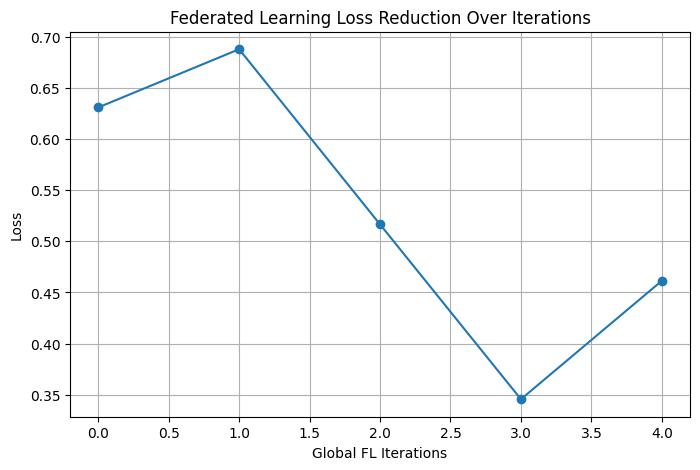

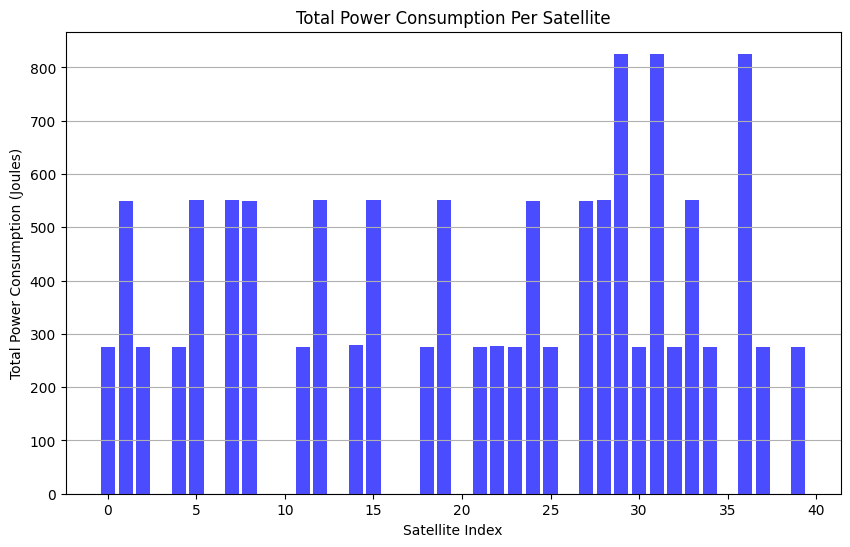


 Checking Transmission Times for Each Satellite:
Satellite 1: Transmission Time = 0.0373 sec
Satellite 2: Transmission Time = 0.0163 sec
Satellite 3: Transmission Time = 0.0910 sec
Satellite 4: Transmission Time = 0.0509 sec
Satellite 5: Transmission Time = 0.0170 sec
Satellite 6: Transmission Time = 0.0471 sec
Satellite 7: Transmission Time = 0.0169 sec
Satellite 8: Transmission Time = 0.0445 sec
Satellite 9: Transmission Time = 0.0155 sec
Satellite 10: Transmission Time = 0.0274 sec
Satellite 11: Transmission Time = 0.0290 sec
Satellite 12: Transmission Time = 0.0706 sec
Satellite 13: Transmission Time = 0.1085 sec
Satellite 14: Transmission Time = 0.0328 sec
Satellite 15: Transmission Time = 0.4121 sec
Satellite 16: Transmission Time = 0.0245 sec
Satellite 17: Transmission Time = 0.2227 sec
Satellite 18: Transmission Time = 0.0165 sec
Satellite 19: Transmission Time = 0.0226 sec
Satellite 20: Transmission Time = 0.0321 sec
Satellite 21: Transmission Time = 0.0196 sec
Satellite 22: 

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

'''
This Python code simulates a Federated Learning (FL) framework in a satellite constellation, 
incorporating scheduling logic and inter-satellite communication constraints. 
It is aligned with the FL approach discussed in the paper and Prism Space's goals of optimizing 
space-based AI compute infrastructure.

### Modifications:
- **Restored Loss Graph** (Tracks loss over global iterations)
- **Fixed Power Calculation** (Idle power applied correctly per epoch)
- **Simplified Power Graph** (Shows power per satellite over training)
- **Better Histogram Representation** (Bins increased for clarity)
- **Debugging Prints** (Optional, useful for inspecting power values)
'''

# --- Simulation Parameters ---
num_sats = 40  # Total satellites
epochs = 5  # Local training epochs
global_iterations = 5  # Number of global updates
visibility_probability = 0.7  # 70% chance a satellite is visible
samples_per_sat = torch.randint(500, 5000, (num_sats,))  # Dataset size per satellite
total_samples = torch.sum(samples_per_sat).item()  # Total dataset size

# Generate Visibility Matrix (1 = Visible, 0 = Not Visible)
visibility_matrix = np.random.choice([0, 1], size=(num_sats, global_iterations), p=[visibility_probability, 1 - visibility_probability])

# --- SATELLITE SPECIFICATIONS ---
power_train = 50  # Watts (Estimated Power for Local Model Training)
power_transmit = 10  # Watts (Estimated Power for Transmission)
power_idle = 5  # Watts (Baseline Idle Power Consumption)
update_size = 1e6  # 1 MB update size

# Transmission Parameters
c = 3e8  # Speed of light (m/s)
transmission_rates = np.random.uniform(1e6, 1e8, size=num_sats)  # 1 Mbps - 100 Mbps
distances = np.random.uniform(500e3, 2000e3, size=num_sats)  # 500 km - 2000 km

# Function to Compute Transmission Time
def compute_transmission_time(data_size, rate, distance):
    return (data_size / rate) + (distance / c)

# --- Create Synthetic Dataset ---
image_size = (3, 32, 32)
X_data = torch.randn(total_samples, *image_size, dtype=torch.float32)  # Ensure float32
Y_data = torch.randint(0, 10, (total_samples,))  # Class labels

# Split data into per-satellite datasets
satellite_datasets = []
start_idx = 0
for sat_idx in range(num_sats):
    end_idx = start_idx + samples_per_sat[sat_idx].item()
    dataset = TensorDataset(X_data[start_idx:end_idx], Y_data[start_idx:end_idx])
    satellite_datasets.append(dataset)
    start_idx = end_idx

# --- Define the FL Model ---
class SatelliteCNN(nn.Module):
    def __init__(self):
        super(SatelliteCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

# --- Train Each Satellite & Compute Power Consumption ---
global_losses = []
power_usage = np.zeros(num_sats)  # Store total power usage per satellite

for global_iter in range(global_iterations):
    print(f"\n Global Iteration {global_iter + 1}")

    visibility = visibility_matrix[:, global_iter]
    local_models = [None] * num_sats  # Initialize list with None values
    local_losses = [0.0] * num_sats  # Ensure same size as num_sats

    for i in range(num_sats):
        if visibility[i] == 1:
            # Compute transmission time
            T_C = compute_transmission_time(update_size, transmission_rates[i], distances[i])

            if T_C < 0.5:
                print(f"Satellite {i+1} training & transmitting (T_C={T_C:.4f} sec)")

                train_loader = DataLoader(satellite_datasets[i], batch_size=32, shuffle=True)

                model = SatelliteCNN()
                optimizer = optim.SGD(model.parameters(), lr=0.01)
                criterion = nn.CrossEntropyLoss()

                # Training Loop
                model.train()
                for epoch in range(epochs):
                    for batch in train_loader:
                        x, y = batch
                        optimizer.zero_grad()
                        outputs = model(x)
                        loss = criterion(outputs, y)
                        loss.backward()
                        optimizer.step()

                # Compute Power Consumption
                power_train_usage = power_train * epochs  # Training power
                power_transmit_usage = power_transmit * T_C  # Transmission power
                power_idle_usage = power_idle * epochs  # Idle power over training period

                power_usage[i] += power_train_usage + power_transmit_usage + power_idle_usage  # Total Power

                local_models[i] = model.state_dict()
                local_losses[i] = loss.item()

    # --- Global Model Aggregation ---
    global_model = SatelliteCNN()
    for param in global_model.state_dict().keys():
        weighted_sum = torch.zeros_like(global_model.state_dict()[param])
        total_weight = 0

        for i in range(num_sats):
            if local_models[i] is not None:
                weighted_sum += (samples_per_sat[i].item() / total_samples) * local_models[i][param]
                total_weight += samples_per_sat[i].item()

        if total_weight > 0:
            global_model.state_dict()[param].copy_(weighted_sum)

    global_loss = sum(local_losses) / len(local_losses)
    global_losses.append(global_loss)
    print("Global Model Updated!")

# --- Visualization Section ---

# **1. Loss Reduction Over Iterations**
plt.figure(figsize=(8, 5))
plt.plot(range(global_iterations), global_losses, marker='o', linestyle='-')
plt.xlabel("Global FL Iterations")
plt.ylabel("Loss")
plt.title("Federated Learning Loss Reduction Over Iterations")
plt.grid(True)
plt.show()

# **2. Power Consumption Per Satellite**
plt.figure(figsize=(10, 6))
plt.bar(range(num_sats), power_usage, color="blue", alpha=0.7)
plt.xlabel("Satellite Index")
plt.ylabel("Total Power Consumption (Joules)")
plt.title("Total Power Consumption Per Satellite")
plt.grid(axis='y')
plt.show()

# --- Check Transmission Delays ---
print("\n Checking Transmission Times for Each Satellite:")
for i in range(num_sats):
    T_C = compute_transmission_time(update_size, transmission_rates[i], distances[i])
    print(f"Satellite {i+1}: Transmission Time = {T_C:.4f} sec")

